In [41]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from sklearn.preprocessing import normalize
from math import ceil
import cortex
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro import flatmaps_helper
from neuro.flatmaps_helper import load_flatmaps
import sasc.viz
from neuro import analyze_helper
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
from neuro.features import qa_questions

setup_freesurfer()

# subject = 'S02'
# subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
subjects = ['S01', 'S02', 'S03']
subject = 'S02'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### ensemble (non-gpt-4) feats each run one at a time

In [ ]:
rr_all = pd.read_pickle('oct17_tmp.pkl')
r = rr_all[rr_all.ndelays == 4]
r = r[r.pc_components == 100]
r = r[r.feature_space == 'qa_embedder']
r = r[r.qa_questions_version == 'v3_boostexamples_merged']
r = r[r.qa_embedding_model == 'ensemble2']
r = r[r.single_question_idx >= 0]
r = r[r.feature_selection_alpha == -1]

In [42]:
ravg = r.groupby(['single_question_idx'])[
    ['corrs_test_mean']].mean().reset_index()
qs = qa_questions.get_merged_questions_v3_boostexamples()
ravg['question'] = ravg['single_question_idx'].apply(lambda i: qs[i])
ravg['q_selected'] = ravg['question'].apply(lambda q: q in QS_35_STABLE)

,single_question_idx,corrs_test_mean,question,q_selected
0,0,0.025322,Does the input contain a measurement?,True
1,1,0.023343,Does the input contain a number?,True
2,2,0.021545,Does the input contain a question?,False
3,3,0.011871,Does the input contain advice or recommendations?,False
4,4,0.021367,Does the input contain an expression of anger?,False
...,...,...,...,...
601,601,0.028886,Does the sentence involve the mention of a spe...,True
602,602,0.012655,Does the sentence mention a family member?,False
603,603,0.014390,Does the sentence mention a past or historical...,False
604,604,0.012713,Does the sentence mention a specific type of c...,False


In [43]:
ravg.to_pickle('corrs_df/single_question_corrs.pkl')

means 0.024616516749857795 0.01474965305918737


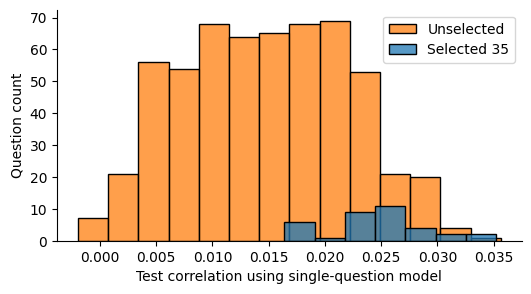

In [66]:
r_selected = ravg[ravg.q_selected]
r_unselected = ravg[~ravg.q_selected]
plt.figure(figsize=(6, 3))
sns.histplot(r_unselected.corrs_test_mean, label='Unselected', color="C1")
sns.histplot(r_selected.corrs_test_mean, label='Selected 35', color="C0")
plt.legend()
plt.xlabel('Test correlation using single-question model')
plt.ylabel('Question count')
print('means', r_selected.corrs_test_mean.mean(),
      r_unselected.corrs_test_mean.mean())
plt.savefig('monosemantic/single_question_perf_hists.pdf', bbox_inches='tight')

In [67]:
ravg['question_abbrev'] = ravg['question'].apply(
    analyze_helper.abbrev_question)
with pd.option_context('display.max_colwidth', None,
                       'display.max_rows', None):
    display(ravg[~ravg.q_selected].sort_values('corrs_test_mean', ascending=False)
            [['question_abbrev', 'corrs_test_mean']].head(20))
print(
    ravg[~ravg.q_selected]
    .sort_values('corrs_test_mean', ascending=False)[['question_abbrev', 'corrs_test_mean']]
    .head(15).to_latex(float_format="%.3f", index=False)
)
print(
    ravg[~ravg.q_selected]
    .sort_values('corrs_test_mean', ascending=False)[['question_abbrev', 'corrs_test_mean']]
    .tail(15).to_latex(float_format="%.3f", index=False)
)

,question_abbrev,corrs_test_mean
340,...contain words with strong visual imagery?,0.035637
450,...part of a narrative?,0.032772
507,...describe an act of communication or interaction with others?,0.030412
563,...describe a an interpersonal misunderstanding or dispute?,0.030407
514,...describe an emotional response to a specific event?,0.030288
284,...mention of a physical object or item?,0.030052
592,...involve a social or interpersonal interaction?,0.029991
600,...involve the description of an emotional response?,0.029959
287,...mention of a scientific fact or concept?,0.029715
562,...describe a an emotional reaction to a surprise or unexpected event?,0.029518


\begin{tabular}{lr}
\toprule
question_abbrev & corrs_test_mean \\
\midrule
...contain words with strong visual imagery? & 0.036 \\
...part of a narrative? & 0.033 \\
...describe an act of communication or interaction with others? & 0.030 \\
...describe a an interpersonal misunderstanding or dispute? & 0.030 \\
...describe an emotional response to a specific event? & 0.030 \\
...mention of a physical object or item? & 0.030 \\
...involve a social or interpersonal interaction? & 0.030 \\
...involve the description of an emotional response? & 0.030 \\
...mention of a scientific fact or concept? & 0.030 \\
...describe a an emotional reaction to a surprise or unexpected event? & 0.030 \\
...use irony or sarcasm? & 0.029 \\
...contain a first-person narrative? & 0.029 \\
...contain a description of an interaction that led to a misunderstanding or conflict? & 0.029 \\
...first-person pronoun in the input? & 0.029 \\
...include a recounting of an impactful or emotional dialogue? & 0.029 \\
\bo

### gpt-4 feats

In [ ]:
rr = pd.read_pickle('oct17_tmp.pkl')

In [ ]:
r = rr
r = r[r.subject == subject]
r = r[r.use_added_wordrate_feature == False]
r = r[r.feature_space == 'qa_embedder']
r = r[r.qa_embedding_model == 'gpt4']
r = r[r.qa_questions_version.str.endswith('?')]  # individual question
r = r[r.ndelays == 4]

In [ ]:
df_selected = pd.read_pickle('../notebooks/monosemantic_df.pkl')

In [ ]:
corrs_dicts = {}
for subj in r.subject.unique():
    r_subj = r[r.subject == subj]
    q_to_corrs = r_subj.set_index(
        'qa_questions_version').corrs_test.to_dict()

    vox_to_q = df_selected[df_selected.subject == 'UT' + subj]
    vox_to_q_dict = vox_to_q.set_index('voxel_idx').question.to_dict()

    corrs = np.zeros(len(vox_to_q_dict))
    for i, (vox, question) in enumerate(tqdm(vox_to_q_dict.items())):
        corrs[i] = q_to_corrs[question][i]

In [ ]:
q_to_corrs

In [ ]:
r_

In [ ]:
len(vox_to_question_dict)

In [ ]:

r_subj.set_index('qa_questions_version')